In [2]:
import torch

# 1. Basic

## 1.1 Torch

In [14]:
x = torch.arange(1,20,2) #range. step=2
print(x,
x.shape,  #元素总数
x.numel(), # number of element
x.reshape(2,5), #相乘==元素数量
torch.zeros((2,2,2)),
torch.ones((2,3,4)).shape,
sep='\n')

tensor([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])
torch.Size([10])
10
tensor([[ 1,  3,  5,  7,  9],
        [11, 13, 15, 17, 19]])
tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])
torch.Size([2, 3, 4])


In [30]:
x = torch.arange(12, dtype=torch.float32).reshape(3,4)
y = torch.tensor([[1,2,3,4], [5,6,7,8], [4,3,2,1]])
print(
    torch.cat((x,y), dim=0).shape, torch.cat((x,y), dim=1).shape,
    x.sum(), 
    x[-1], # 最后一行
    x[1:3,],
    x[0:2,::],
sep='\n')

torch.Size([6, 4])
torch.Size([3, 8])
tensor(66.)
tensor([ 8.,  9., 10., 11.])
tensor([[ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])
tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])


In [ ]:
# broadcasting mechanism
a = torch.arange(3).reshape((3,1))
b = torch.arange(2).reshape((1,2))
a, b
a + b #!

tensor([[0, 1],
        [1, 2],
        [2, 3]])

## 1.2 Data Processing

In [32]:
import os, pandas as pd

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
file = os.path.join('..', 'data', 'house_tiny.csv')
with open(file, 'w') as f:
    f.write('NumRooms, Alley, Price\n')
    f.write('NA, Pave, 127500\n')
    f.write('2,NA,10600\n')

data = pd.read_csv(file)
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,10600


In [35]:
# missing data
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]
inputs

,NumRooms,Alley
0,NaN,Pave
1,2.0,NaN


## 1.3 Grad

In [20]:
x = torch.arange(4.0)
x.requires_grad_(True)
x.grad

In [21]:
y = 2 * torch.dot(x,x)
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

In [14]:
x.grad.zero_()
y = x.sum().backward()
x.grad

tensor([1., 1., 1., 1.])

In [24]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a.grad == d / a

tensor(True)

# 2. Linear Regression

## 2.1 手搓

In [32]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

features: tensor([-1.9059, -0.0791]) 
label: tensor([0.6689])


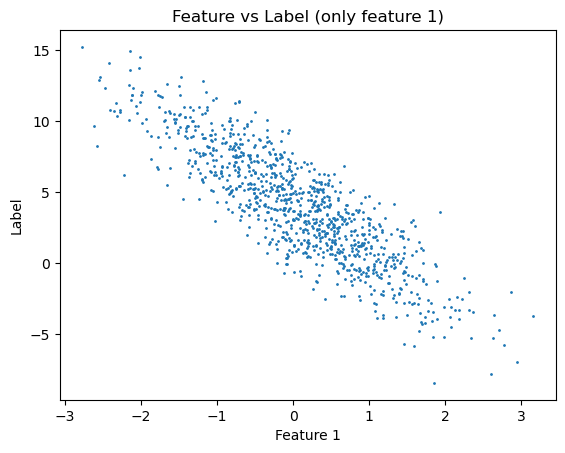

In [45]:
# 构造数据集

def synthetic_data(w, b, num_examples):
    '''
    生成 y = Xw + b
    x.shape = (num_examples, len(w))
    y(output) = (num_examples, 1)
    '''
    X = torch.normal(0, 1, (num_examples, len(w))) # x变成长度为w的数值
    y = torch.matmul(X,w) + b # y = Xw + b
    y += torch.normal(0, 0.01, y.shape) # y = Xw + b + e add random noise
    return X, y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])

# Visualize
plt.scatter(features[:, 1].numpy(), labels.numpy(), s=1)
plt.xlabel('Feature 1')
plt.ylabel('Label')
plt.title('Feature vs Label (only feature 1)')
plt.show()

In [68]:
# Data iter 

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for x, y in data_iter(batch_size, features, labels):
    print(x, '\n', y)
    break

tensor([[-0.3614,  0.2485],
        [-0.3003, -2.0552],
        [ 0.2149, -1.5506],
        [ 0.9829, -0.0128],
        [ 1.8659, -1.0553],
        [-0.8009,  0.9565],
        [ 0.0916, -1.1183],
        [-1.2005,  1.0100],
        [-1.4263, -0.1418],
        [-0.9924,  0.5502]]) 
 tensor([[ 2.6368],
        [10.5714],
        [ 9.9070],
        [ 6.1955],
        [11.5150],
        [-0.6801],
        [ 8.1846],
        [-1.6174],
        [ 1.8274],
        [ 0.3408]])


In [75]:
# initialize
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [76]:
# model
def linreg(X, w, y):
    return torch.matmul(X, w) + b

# loss
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

# optimalize - 随机梯度下降 Stochastic Gradient Descent
def sgd(params, lr, batch_size):
    with torch.no_grad(): # 这段不参与反向传播计算图的构建
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [83]:
# training

lr = 0.01
num_epochs = 10
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # l.shape = (batch_size, 1)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {train_l.mean():.6f}')

epoch 1, loss 0.349376
epoch 2, loss 0.051875
epoch 3, loss 0.007759
epoch 4, loss 0.001198
epoch 5, loss 0.000222
epoch 6, loss 0.000075
epoch 7, loss 0.000053
epoch 8, loss 0.000050
epoch 9, loss 0.000049
epoch 10, loss 0.000049


In [84]:
# Compare
print(f'true_w: {true_w} \n w: {w.reshape(true_w.shape)}')
print(f'true_b: {true_b} \n b: {b}')

true_w: tensor([ 2.0000, -3.4000]) 
 w: tensor([ 1.9990, -3.3999], grad_fn=<ViewBackward0>)
true_b: 4.2 
 b: tensor([4.1997], requires_grad=True)


## 2.2 调api

In [87]:
from torch.utils import data

# Create dataset
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [89]:
# Data loader
def load_array(data_array, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_array)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-1.7619, -0.1383],
         [ 1.3247,  1.8869],
         [ 2.0361, -0.5793],
         [-0.2849,  0.0429],
         [ 0.4102,  0.1315],
         [ 0.4299,  1.0352],
         [-0.4516,  1.7103],
         [ 1.0572, -0.0455],
         [-2.0566, -0.1985],
         [ 0.5684, -0.5029]]),
 tensor([[ 1.1330],
         [ 0.4250],
         [10.2520],
         [ 3.4935],
         [ 4.5921],
         [ 1.5322],
         [-2.5277],
         [ 6.4609],
         [ 0.7507],
         [ 7.0231]])]

In [92]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0, 0.01) #.normal_(mean, std) 初始化权重
net[0].bias.data.fill_(0) # 把偏置 bias 全部设置为 0（常见做法）， fill_表示in place

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.01)

In [93]:
num_epochs = 5
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.608218
epoch 2, loss 0.011895
epoch 3, loss 0.000345
epoch 4, loss 0.000109
epoch 5, loss 0.000104


# 3. Softmax

In [94]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

In [ ]:
# 